# Demo redes Recursivas (LSTM o GRU) para clasificar (atributo clase discreto) o estimar (atributo clase continuo) usando Serie Temporal
Basado en https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ 

In [ ]:
#@title Librerías a usar
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import os
import csv

print("Librerías cargadas")

Librerías cargadas


In [ ]:
#@title Acceder al Drive

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [ ]:
#@title Cargar datos

## selección de los parámetros 

def cargarNombreClases(path, archivo_datos, atributo_clase, nombre_clases):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return atributo_clase, nombre_clases

#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'CLIMA.csv'  #@param {type:"string"}
#@markdown ### Nombre del atributo clase / objetivo:
atributo_clase = 'CantLluvia' #@param {type:"string"}
#@markdown ### Descripción de los valores del atributo clase / objetivo:  (nota: siempre debe comienzar en 0, por lo que si no tiene valor 0, agregar "na")
nombre_clases = '-' #@param {type:"string"}

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos)
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())


# intenta cargar configuración asociada a los datos
if atributo_clase == '' or  atributo_clase == '-':
  # trata de obtener la configuración del archivo asociado
  atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos, atributo_clase, nombre_clases)

# define nombre atributo de CLASE para ejemplo IRIS
ClassAttributeName = atributo_clase

print("\n> Atributo clase ", ClassAttributeName, ": [", nombre_clases, "]")

# genera los datos solo con la clase para entrenar y probar
Yori = np.array(df.pop(ClassAttributeName))
Xori = np.array(df)


Archivo de datos  CLIMA.csv  cargado

> Cabecera: 
   MaxTemp  MinTemp  CantLluvia  VelViento    Humedad   RadSolar
0     28.0   16.851         0.0   4.115179  54.014606  34.023094
1     29.0   15.581         0.0   3.828738  54.534280  33.991928
2     33.0   19.627         0.0   4.481996  50.441004  29.988900
3     35.0   19.131         0.0   4.038467  47.209254  30.184419
4     29.0    8.614         0.0   2.751128  34.174579  27.685916

> Características: 
            MaxTemp       MinTemp    CantLluvia     VelViento       Humedad  \
count  25974.000000  25974.000000  25974.000000  25974.000000  25974.000000   
mean      23.306640     12.267206      2.681185      3.953890     64.749881   
std        7.795314      5.563365      9.276417      1.298974     17.197800   
min        6.000000     -3.734000      0.000000      0.879855     13.768390   
25%       17.000000      8.087250      0.000000      3.021895     52.244933   
50%       23.000000     12.292000      0.000000      3.816113   

In [ ]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = False #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(Xori[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler": 
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler": 
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler": 
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler": 
    scaler = preprocessing.RobustScaler()
  
  # normaliza los datos de entrada
  X = scaler.fit_transform(X)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(Xori[:10])

In [ ]:
#@title Generar secuencia de datos como Serie

cantidad_intervalos_secuencia = 3 #@param {type:"integer"}

usar_atributos_secuencia = "Todos" #@param ["Solo atributo a Estimar", "Solo atributos de Entrada", "Todos"]

if cantidad_intervalos_secuencia < 1:
  cantidad_intervalos_secuencia = 1

# funciones auxilliares
def split_sequence(datosX, datosY, n_steps, atr_seq):
  x, y = [], []
  if len(datosX) != len(datosY):
    print("No coincide el largo de los datos X e Y!!!")
    return None, None
  for i in range(len(datosY)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(datosY)-1:
      break
    # gather input and output parts of the pattern
    if atr_seq == "Y":
      # sólo atributo a estimar (anteriores)
      seq_x = datosY[i:end_ix]
      seq_y = datosY[end_ix]   
    elif atr_seq == "X":
      # sólo atributos de entrada (anteriores y actuales)
      seq_x = datosX[i:end_ix]
      seq_y = datosY[end_ix-1]   
    else:
      # atributos de entrada y a estimar (anteriores)
      seq_xa = datosX[i:end_ix]
      seq_xb = datosY[i:end_ix] 
      seq_y = datosY[end_ix]  
      seq_x = []
      for xa, xb in zip(seq_xa, seq_xb):        
        xa = list(xa)
        xa.append(xb)
        seq_x.append(xa)

    x.append( seq_x )
    y.append( seq_y )
  return np.array(x), np.array(y)

# muestra los primeros "cant" datos
def mostrarEjemplos(X, Y, cant=5):
  for i in range(min(len(X), cant)):
    print(X[i], Y[i])
  print("\n")

print("\n> Antes de generar serie: ")
mostrarEjemplos(Xori, Yori)

# genera secuencias
print("> Generando series con ", cantidad_intervalos_secuencia ," intervalos ")
if (Xori.shape[1] == 0) or usar_atributos_secuencia == "Solo atributo a Estimar": 
  atrSeq = "Y"
  cant_atributos_entrada = 1
elif usar_atributos_secuencia == "Solo atributos de Entrada":
  atrSeq = "X"
  cant_atributos_entrada = Xori.shape[1]
else: # "Todos"
  atrSeq = "XY"
  cant_atributos_entrada = Xori.shape[1] + 1
X, Y = split_sequence(Xori, Yori, cantidad_intervalos_secuencia, atrSeq)

print("\n> Después de generar serie: ")
mostrarEjemplos(X, Y)



> Antes de generar serie: 
[28.         16.851       4.11517889 54.01460647 34.02309402] 0.0
[29.         15.581       3.82873837 54.53428037 33.9919281 ] 0.0
[33.         19.627       4.48199627 50.44100419 29.98889964] 0.0
[35.         19.131       4.03846654 47.20925441 30.18441906] 0.0
[29.          8.614       2.75112845 34.17457853 27.6859161 ] 0.0


> Generando series con  3  intervalos 

> Después de generar serie: 
[[28.         16.851       4.11517889 54.01460647 34.02309402  0.        ]
 [29.         15.581       3.82873837 54.53428037 33.9919281   0.        ]
 [33.         19.627       4.48199627 50.44100419 29.98889964  0.        ]] 0.0
[[29.         15.581       3.82873837 54.53428037 33.9919281   0.        ]
 [33.         19.627       4.48199627 50.44100419 29.98889964  0.        ]
 [35.         19.131       4.03846654 47.20925441 30.18441906  0.        ]] 0.0
[[33.         19.627       4.48199627 50.44100419 29.98889964  0.        ]
 [35.         19.131       4.0384665

In [ ]:
#@title Preparar datos 

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "continuo - ESTIMACION" #@param ["dicreto - CLASIFICACION", "continuo - ESTIMACION"] 

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")


# reshape de [cant ejemplos, datos entrada] into [cant ejemplos, intervalos, datos entrada]
X =  X.reshape((X.shape[0], cantidad_intervalos_secuencia, cant_atributos_entrada))

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado 
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y)
  except ValueError:
    print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain))
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain))

CLASES = []
if esProblemaClasificacion:
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases     
  if (nombre_clases == "") or (nombre_clases == "-"):
      # toma los valores de clase orginales del archivo
      for val in range(np.max(Y)+1):
        CLASES.append( "clase {:>3}".format(val) )
  else:
      # toma configuración de nombre de clases
      for val in nombre_clases.split(','):
        CLASES.append( val )

  # genera salida codificada para softMax
  y_trainEnc =  np_utils.to_categorical(y_train)
  y_testEnc =  np_utils.to_categorical(y_test)

  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES)
else:
  print("> se considera problema de ESTIMACIÓN \n")

  y_trainEnc = []
  y_testEnc =  []


print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, intervalos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_train:
      if i == y: cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, intervalos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_test:
      if i == y: cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)


> se considera problema de ESTIMACIÓN 


> Para Entrenamiento: 
 - x_train (cant ejemplos, intervalos, datos entrada):  (19478, 3, 6)
 - y_train (cant):  19478

 Para Prueba: 
 - x_test (cant ejemplos, intervalos, datos entrada):  (6493, 3, 6)
 - y_test (cant):  6493


-- se considera salida lineal porque es problema de Estimación!
Modelo creado con  5  capas:
Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (GRU)                 (None, 3, 150)            71100     
                                                                 
 oculta (GRU)                (None, 150)               135900    
                                                                 
 flat (Flatten)              (None, 150)               0         
                                                                 
 d_1 (Dropout)               (None, 150)               0         
                                                                 
 output (Dense)              (None, 1)                 151       
                                                                 
Total params: 207,151
Trainable params: 207,151
Non-trainable params: 0
______________________________

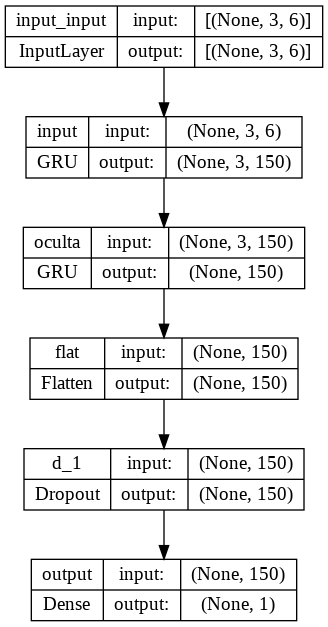

In [ ]:
#@title Establecer modelo

#@markdown ### Parámetros de las capas RNN:

rnn_tipo_red = "Stacked" #@param ["Simple", "Stacked", "Bidirectional"] 
rnn_tipo_capa = "GRU" #@param ["LSTM", "GRU"]
rnn_cant_neuronas = 150 #@param {type: "integer"}

#@markdown ### Parámetros de las capas Lineales:
lineal_cant_neuronas_capas_ocultas = 'D' #@param {type:"string"}
#@markdown (Nota: se puede indicar Cantidad de neuronas, D para DropOut, BN para BatchNormalization)
lineal_porc_capa_DropOut = 0.4 #@param {type:"number"}

#@markdown ### Parámetros de la capa de Salida:
red_tipo_capa_salida = 'softmax-MultiClase' #@param ["lineal-Numero", "softmax-MultiClase"]

#@markdown ### Parámetros del Optimizador:
opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.001 #@param {type: "number"}


## aplicación de los parámetros elegidos

# chequea configuración de drop out
if lineal_porc_capa_DropOut <= 0:
  lineal_porc_capa_DropOut = 0.10
elif lineal_porc_capa_DropOut > 0.9:
    lineal_porc_capa_DropOut = 0.9
  
# cantidad de neuronas ocultas 
hidden_layers = []
for val in lineal_cant_neuronas_capas_ocultas.split(','):
  val = val.strip()
  if val == "D":
    hidden_layers.append( "DropOut" )  
  elif val == "BN":
    hidden_layers.append( "BatchNormalization" )  
  elif val.isnumeric():
    hidden_layers.append( val )
  else:
    print("Capa ", val, "descartada!")


# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
if esProblemaClasificacion:
  tipo_output_softMax = (red_tipo_capa_salida[:7] == 'softmax')
else:
  print("-- se considera salida lineal porque es problema de Estimación!")
  tipo_output_softMax = False

if rnn_cant_neuronas < 5:
  rnn_cant_neuronas = 5

# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente
model = tf.keras.models.Sequential(name="RNN")
if rnn_tipo_red == "Simple":

  # una capa
  if rnn_tipo_capa == "LSTM":     
    model.add( tf.keras.layers.LSTM(rnn_cant_neuronas, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), name="input") )    
  else:
    model.add( tf.keras.layers.GRU(rnn_cant_neuronas, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), name="input") )

elif rnn_tipo_red == "Stacked":
  # dos capas 
  if rnn_tipo_capa == "LSTM":
    model.add( tf.keras.layers.LSTM(rnn_cant_neuronas, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), name="input") )
    model.add( tf.keras.layers.LSTM(rnn_cant_neuronas, activation='relu', name="oculta") )
  else:
    model.add( tf.keras.layers.GRU(rnn_cant_neuronas, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), name="input") )
    model.add( tf.keras.layers.GRU(rnn_cant_neuronas, activation='relu', name="oculta") )

elif rnn_tipo_red == "Bidirectional":
  # una capa bidireccional
  if rnn_tipo_capa == "LSTM":
    model.add( tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_cant_neuronas, activation='relu', name="bdir_LSTM"), input_shape=(x_train.shape[1], x_train.shape[2]), name="bdirecc_LSTM") )
  else:
    model.add( tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_cant_neuronas, activation='relu', name="bdir_GRU"), input_shape=(x_train.shape[1], x_train.shape[2]), name="bdirecc_GRU") ) 
    
else:
  print("Tipo de red inválida: ", rnn_tipo_red, "!!!")

if len(hidden_layers) > 0:
  model.add( tf.keras.layers.Flatten(name="flat") )

# agrega capas lineales
auxName = 'lineal_'
auxId = 1 
for val_hid in hidden_layers:  

  if val_hid == "DropOut":
    auxlayerName = "d_"+str(auxId)
    auxId = auxId + 1
    model.add(  tf.keras.layers.Dropout(lineal_porc_capa_DropOut,name=auxlayerName) )
  elif val_hid == "BatchNormalization":
    auxlayerName = "bn_"+str(auxId)
    auxId = auxId + 1
    model.add( tf.keras.layers.BatchNormalization(name=auxlayerName) )
  elif val_hid.isnumeric():
    # agrega la capa oculta
    auxlayerName = auxName+str(auxId)
    auxId = auxId + 1
    model.add( tf.keras.layers.Dense(int(val_hid), name=auxlayerName) ) # capas ocultas

# agrega capa de salida
if esProblemaClasificacion and tipo_output_softMax:
    # se genera una capa softmax
   model.add( tf.keras.layers.Dense(units = len(CLASES), activation='softmax', name='output') ) # capa de salida
else:
    # se genera una capa lineal con una salida numérica
    model.add( tf.keras.layers.Dense(1, activation=None, name='output') ) # capa de salida

if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam()

# genera el modelo 
if tipo_output_softMax:
    # utiliza un loss de multiple clases
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
else:
    # utiliza un loss de valor numérico
    if esProblemaClasificacion:
      model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
    else:
      model.compile(optimizer=opt, loss='mse', metrics=['RootMeanSquaredError'])

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)




In [ ]:
#@title Entrenar

cant_epocas_entrenamiento = 150 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
cantEpocas = (1 if cant_epocas_entrenamiento<1 else cant_epocas_entrenamiento)

activar_corte_por_estabilidad_error_val = False #@param {type:"boolean"}

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                       (y_trainEnc if tipo_output_softMax else y_train), 
                                       test_size=0.1)


print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

if activar_corte_por_estabilidad_error_val:
  # se agrega un callBack para que corte 
  # si el error de validación no sigue bajando
  # y devuelva los mejores pesos obtenidos
  early_stopping_monitor = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0.01,
      patience=20,
      verbose=0,
      mode='min',
      baseline=None,
      restore_best_weights=True
  )
  callbacksEntr = [early_stopping_monitor]
else:
  early_stopping_monitor = None
  callbacksEntr = []

# lleva a cabo el entrenamiento
history = model.fit(x_t, y_t,
          epochs = cantEpocas, 
          validation_data=(x_v, y_v,),
          callbacks=callbacksEntr ) 

print("\n>Entrenamiento Finalizado.")



> De los  19478 ejemplos de entrenamiento: 
            se usan  17530 ejemplos para entrenar 
            y  1948 ejemplos para validar.


>Comienza el Entrenamiento:
Epoch 1/150
548/548 [==============================] - 13s 18ms/step - loss: 55.0745 - root_mean_squared_error: 7.4212 - val_loss: 66.5923 - val_root_mean_squared_error: 8.1604
Epoch 2/150
548/548 [==============================] - 9s 17ms/step - loss: 49.5923 - root_mean_squared_error: 7.0422 - val_loss: 67.2242 - val_root_mean_squared_error: 8.1990
Epoch 3/150
548/548 [==============================] - 10s 18ms/step - loss: 49.3718 - root_mean_squared_error: 7.0265 - val_loss: 67.1596 - val_root_mean_squared_error: 8.1951
Epoch 4/150
548/548 [==============================] - 10s 18ms/step - loss: 48.8226 - root_mean_squared_error: 6.9873 - val_loss: 66.9805 - val_root_mean_squared_error: 8.1842
Epoch 5/150
548/548 [==============================] - 10s 17ms/step - loss: 49.1123 - root_mean_squared_error: 7.0080 - val

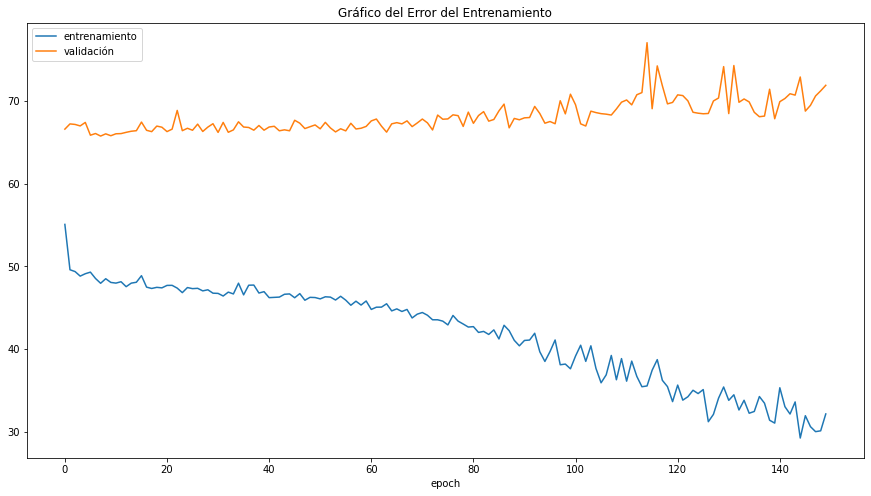

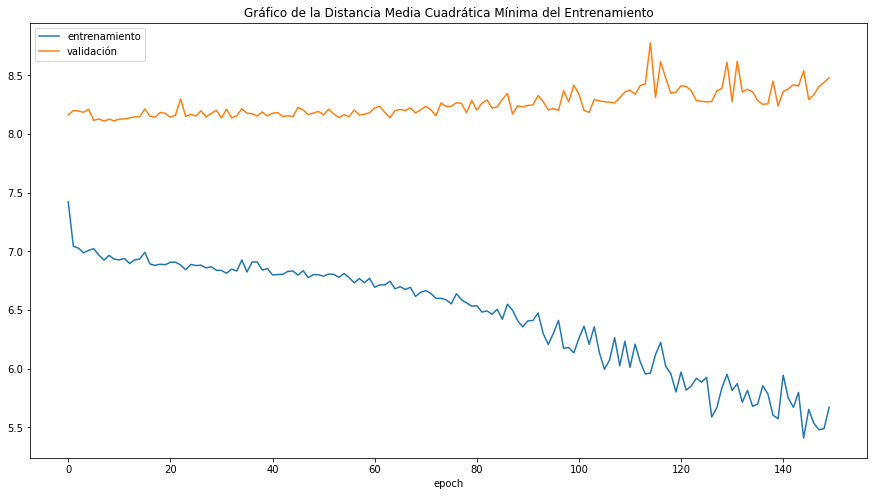

In [ ]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8)) 
if esProblemaClasificacion:
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Gráfico de la Exactitud del Entrenamiento')
else:
  plt.plot(history.history['root_mean_squared_error'])
  plt.plot(history.history['val_root_mean_squared_error'])
  plt.title('Gráfico de la Distancia Media Cuadrática Mínima del Entrenamiento')
  
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

*** Resultados con datos de Entrenamiento: 



 Error Absoluto: 
            Mínimo: 0.00013 
            Promedio: 2.14469 ± 5.19665
            Máximo: 170.03744 


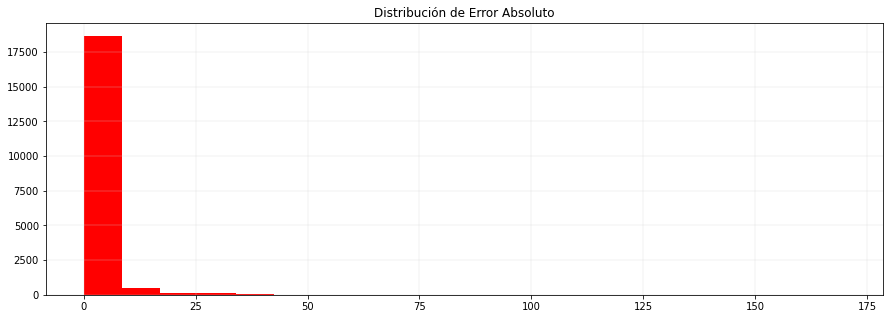


 Error Relativo: 
            Mínimo: 0.01% 
            Promedio: 8796193.25 ± 14295122.31
            Máximo: 495061759.95% 


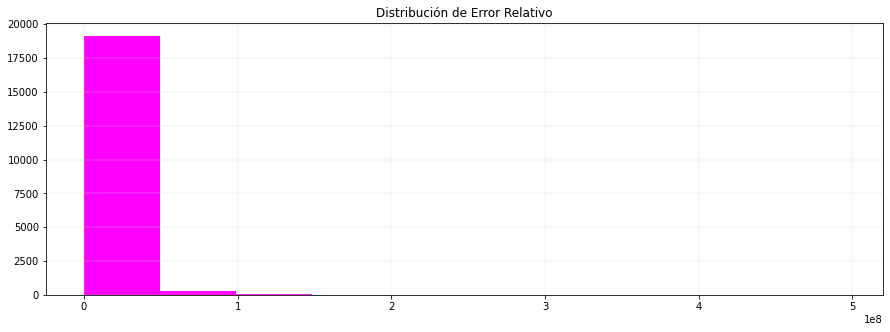

In [ ]:
#@title Probar red entrenada con datos de entrenamiento

mostrar_detalle_entrenamiento = False #@param {type:"boolean"}

# función auxiliar para el cálculo de error
def calcErrores(pred, real, mostrarDetalle=False):
  arAbs = []
  arRel = []
  
  if mostrarDetalle:
    print("\n")
    print("\t Real \t\t\t Estimado \t\t Error Absoluto \t Error Relativo")

  for pV, r in zip(pred, real):
    # toma el valor estimado/predecido
    p = pV[0]
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)
    
      if mostrarDetalle:
        print("\t{:>8.2f} \t\t {:>8.2f} \t\t {:>8.2f} \t\t {:>8.2f}%".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5)) 
 #   ax = fig.add_axes( [0, 0, 0.8, 0.8] )
 #   ax.boxplot( [arAbs, arRel] )
 #   ax.set_xticklabels( ["Error Absoluto", "Error Relativo"] )
#    plt.legend(["Error Absoluto", "Error Relativo"], loc='best')
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Estimacion(x, y, detalle=False):

    # procesa las imágenes de prueba con el modelo 
    estimVals = model.predict(x, verbose=0)

    # llama a la función
    arAbs, arRel = calcErrores(estimVals, y, detalle)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.5f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.5f} ± {:.5f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.5f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")
    
    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Clasificacion(x, y, clases_map, mostrarDetalle=False):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x, verbose=0)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ] 

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]       
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA"
        else:      
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = 'Real: ' + str(clReal) + ' / Modelo(RNA): ' 
        strTitulo = strTitulo + str(clPred) + ' (' + str( idclPred ) +')'   
        strTitulo = strTitulo + ": " + ("ok" if (clPred==clReal) else "error!")

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)    
    print(cmtx)
    print("\n")

    # gráfico de comparación
    plt.title('Gráfico de Confusión: ')
    plt.xlabel('Real')
    plt.ylabel('Modelo')
    plt.scatter(classReal, classPreds)

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_train, y_train, CLASES, mostrar_detalle_entrenamiento)
else:
  probarModelo_Estimacion(x_train, y_train, mostrar_detalle_entrenamiento)


6) Evaluar el modelo de la RNA entrenado con los datos de prueba:

Se han truncado las últimas 5000 líneas del flujo de salida.
	    0.00 		     0.58 		     0.58 		 5818033.22%
	    0.00 		     0.64 		     0.64 		 6395151.62%
	    2.00 		     0.67 		     1.33 		    66.68%
	    0.00 		     0.28 		     0.28 		 2765418.89%
	    0.00 		     0.85 		     0.85 		 8537253.14%
	    0.00 		     5.00 		     5.00 		 50023727.42%
	    0.00 		    -0.02 		     0.02 		 248281.96%
	    0.00 		    -0.03 		     0.03 		 254410.51%
	    0.00 		    27.94 		    27.94 		 279433307.65%
	    0.00 		     3.02 		     3.02 		 30200388.43%
	    0.00 		     1.73 		     1.73 		 17269032.00%
	   11.00 		    14.08 		     3.08 		    27.99%
	    0.00 		     1.24 		     1.24 		 12388479.71%
	  101.00 		    81.06 		    19.94 		    19.75%
	    0.00 		     0.91 		     0.91 		 9065351.49%
	    2.00 		     0.75 		     1.25 		    62.48%
	    0.00 		     0.64 		     0.64 		 6390199.66%
	    0.00 		     0.67 		     0.67 		 6659132.24%
	    0.00 		     1.53 		     1.53 		 15267524.72%
	    0.00 	

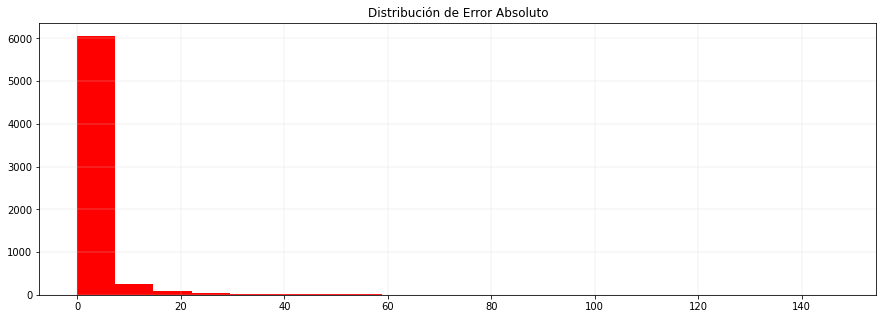


 Error Relativo: 
            Mínimo: 0.00% 
            Promedio: 10908382.96 ± 26724642.01
            Máximo: 1059005050.66% 


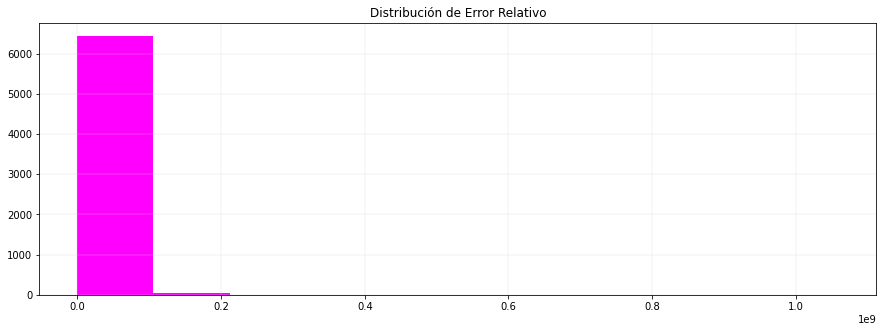

In [ ]:
#@title Probar red entrenada con datos de prueba
mostrar_detalle_prueba = True #@param {type:"boolean"}

  # evalua al modelo entrenado
resEval = model.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test), verbose=0)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", round(resEval[0],3))
if esProblemaClasificacion:
  print("    - Exactitud: ", round(resEval[1]*100,2))
else:
  print("    - Distancia Media Cuadrática Mínima: ", round(resEval[1],3))
  
#print("\n")

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_test, y_test, CLASES, mostrar_detalle_prueba)
else:
  probarModelo_Estimacion(x_test, y_test, mostrar_detalle_prueba)
